In [ ]:
# Imports
import importlib.util, os
import numpy as np
import pandas as pd

from sklearn.pipeline import FunctionTransformer
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
import pickle
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import NearestNeighbors

# Custom imports for visualisation
spec = importlib.util.spec_from_file_location("utilities", os.path.join("..", "Python-Files", "utilities.py"))
utilities = importlib.util.module_from_spec(spec)
spec.loader.exec_module(utilities)
line_graph = utilities.line_graph
boxplot = utilities.boxplot

# Constants
K_FOLDS = 5
RANDOM_STATE = 420

# Settings
pd.set_option('display.max_columns', None)

# Import data and split
data = pd.read_csv('../Processed-Datasets/forestCover-Preprocessed.csv')
train, test = train_test_split(data, test_size=0.2, random_state=42)

In [2]:
# Training a base model
cross_validation = KFold(
    n_splits=K_FOLDS,
    shuffle=True,
    random_state=RANDOM_STATE
)

param_grid = {'knn__n_neighbors': range(1,11)}

# Use weighted due to class imbalance, with robust scaler for outliers
pipeline = Pipeline([
    ("scaler", RobustScaler(unit_variance=True)), 
    ("knn", KNeighborsClassifier(weights='distance'))
])

# -1 for all cores and 3 for to show progress
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cross_validation,
    scoring='f1_macro',
    verbose=3,
    n_jobs=-1
)

# Take a 25% subset
train_subset = train.sample(n=int(train.shape[0]*0.1), random_state=RANDOM_STATE, replace=False)

grid_search.fit(
    X=train_subset.drop(columns=['Cover_Type']), 
    y=train_subset['Cover_Type']
)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 5/5] END ................knn__n_neighbors=1;, score=0.754 total time=   3.1s
[CV 1/5] END ................knn__n_neighbors=1;, score=0.733 total time=   3.8s
[CV 1/5] END ................knn__n_neighbors=2;, score=0.733 total time=   3.5s
[CV 2/5] END ................knn__n_neighbors=2;, score=0.738 total time=   3.3s
[CV 2/5] END ................knn__n_neighbors=1;, score=0.738 total time=   3.9s
[CV 4/5] END ................knn__n_neighbors=1;, score=0.725 total time=   3.7s
[CV 3/5] END ................knn__n_neighbors=2;, score=0.765 total time=   3.9s
[CV 3/5] END ................knn__n_neighbors=1;, score=0.765 total time=   4.1s
[CV 4/5] END ................knn__n_neighbors=2;, score=0.725 total time=   4.3s
[CV 5/5] END ................knn__n_neighbors=2;, score=0.754 total time=   4.0s
[CV 2/5] END ................knn__n_neighbors=3;, score=0.747 total time=   3.5s
[CV 1/5] END ................knn__n_neighbors=3;

,estimator,Pipeline(step...'distance'))])
,param_grid,"{'knn__n_neighbors': range(1, 11)}"
,scoring,'f1_macro'
,n_jobs,-1
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,3
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,with_centering,True


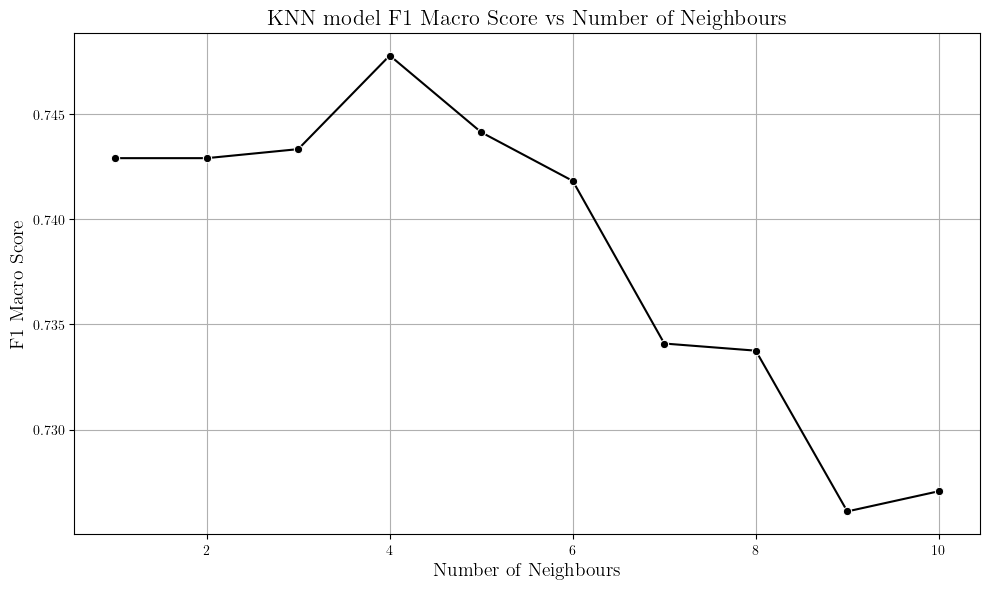

In [5]:
line_graph(
    x=[int(x) for x in grid_search.cv_results_['param_knn__n_neighbors'].data],
    y=grid_search.cv_results_['mean_test_score'],
    x_label='Number of Neighbours',
    y_label='F1 Macro Score',
    title='KNN model F1 Macro Score vs Number of Neighbours',
    save_dir='../Generated-Figures/KNN-F1-Neighbours-25Data.png'
)

In [ ]:
with open('../Pickle-Files/KNN-Model-Grid-Search-1.pkl', 'wb') as f:
    pickle.dump(grid_search.best_estimator_, f)

In [ ]:
# Use weighted due to class imbalance, with robust scaler for outliers
pipeline = Pipeline([
    ("scaler", RobustScaler(unit_variance=True)), 
    ("knn", KNeighborsClassifier(weights='distance', 
                                 n_neighbors=4))
])

pipeline.fit(
    X=train.drop(columns=['Cover_Type']), 
    y=train['Cover_Type']
)

,steps,"[('scaler', ...), ('knn', ...)]"
,transform_input,None
,memory,None
,verbose,False
,with_centering,True
,with_scaling,True
,quantile_range,"(25.0, ...)"
,copy,True
,unit_variance,True
,n_neighbors,4
,weights,'distance'


In [4]:
preds = pipeline.predict(test.drop(columns=['Cover_Type']))
print(classification_report(test['Cover_Type'], preds))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93     42487
           1       0.94      0.95      0.94     56659
           2       0.91      0.92      0.91      7123
           3       0.88      0.83      0.85       570
           4       0.83      0.79      0.81      1860
           5       0.83      0.83      0.83      3480
           6       0.94      0.94      0.94      4024

    accuracy                           0.93    116203
   macro avg       0.90      0.88      0.89    116203
weighted avg       0.93      0.93      0.93    116203



In [ ]:
# Use a low value of k to start since the computation time increases with k
pipeline = Pipeline([
    ("scaler", RobustScaler(unit_variance=True)),
    ("smote", SMOTE(k_neighbors=3,
                    random_state=RANDOM_STATE)),
    ("knn", KNeighborsClassifier(weights='distance', 
                                 n_neighbors=4))
])

pipeline.fit(
    X=train.drop(columns=['Cover_Type']), 
    y=train['Cover_Type']
)

,steps,"[('scaler', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,with_centering,True
,with_scaling,True
,quantile_range,"(25.0, ...)"
,copy,True
,unit_variance,True
,sampling_strategy,'auto'
,random_state,420


In [3]:
preds = pipeline.predict(test.drop(columns=['Cover_Type']))
print(classification_report(test['Cover_Type'], preds))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93     42487
           1       0.95      0.93      0.94     56659
           2       0.90      0.92      0.91      7123
           3       0.81      0.85      0.83       570
           4       0.68      0.91      0.77      1860
           5       0.79      0.87      0.83      3480
           6       0.90      0.97      0.93      4024

    accuracy                           0.93    116203
   macro avg       0.85      0.91      0.88    116203
weighted avg       0.93      0.93      0.93    116203

